Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

INFO:tensorflow:Assets written to: ./bert_models/1670690385.641988/assets


INFO:tensorflow:Assets written to: ./bert_models/1670690385.641988/assets


Message: "Greg, can you call me back once you get this?"
Likeliness of spam in percentage: 0.000258
Vote by AI: Not Spam
Model predicted correctly


Message: "Congrats on your new iPhone! Click here to claim your prize..."
Likeliness of spam in percentage: 0.858939
Vote by AI: Spam
Model predicted correctly


Message: "Really like that new photo of you"
Likeliness of spam in percentage: 0.007752
Vote by AI: Not Spam
Model predicted correctly


Message: "Did you hear the news today? Terrible what has happened..."
Likeliness of spam in percentage: 0.000284
Vote by AI: Not Spam
Model predicted correctly


Message: "Attend this free COVID webinar today: Book your session now..."
Likeliness of spam in percentage: 0.998953
Vote by AI: Spam
Model predicted correctly


Message: "Are you coming to the party tonight?"
Likeliness of spam in percentage: 0.007384
Vote by AI: Not Spam
Model predicted correctly


Message: "Your parcel has gone missing"
Likeliness of spam in percentage: 0.003767
Vote 

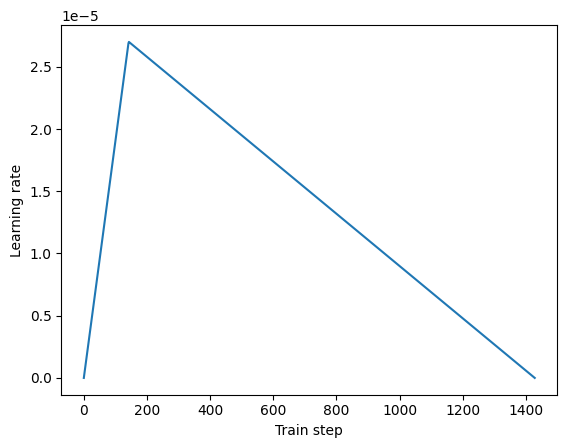

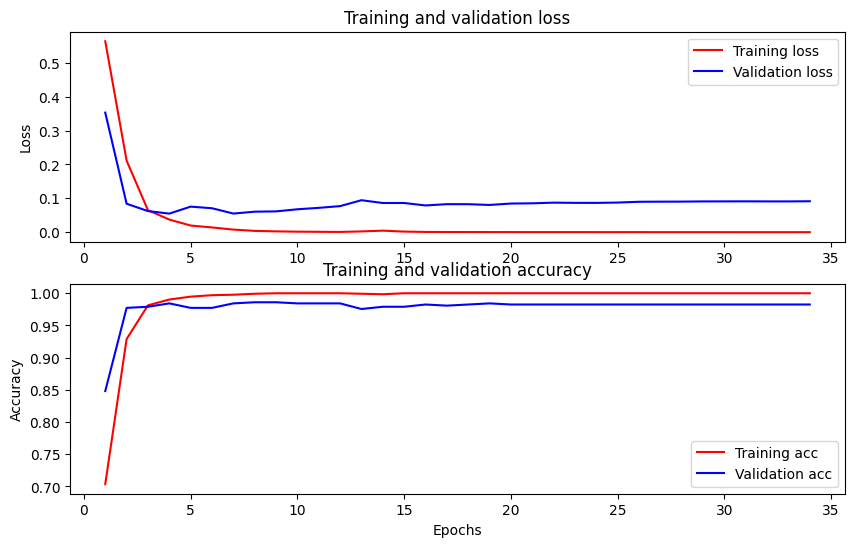

In [2]:
!pip3 install --quiet tensorflow-text numpy pandas tf-models-official

import csv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_models as tfm
#from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_text as text # needed even if unused
import time

import matplotlib.pyplot as plt

def change_labels(x):
    return 1 if x == "spam" else 0

data = pd.read_csv(
    "./input/MatrixData.tsv", sep="\t", quoting=csv.QUOTE_NONE, encoding="utf-8"
)

# Minimum length
data = data[data["message"].str.split().str.len().gt(18)]
# Remove unknown
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data["label"] = data["label"].apply(change_labels)

# Remove stopwords
#data["message"] = data["message"].apply(remove_stopwords)
# Shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# Split data into messages and label sets
sentences = data["message"].tolist()
labels = data["label"].tolist()

# Separate out the sentences and labels into training and test sets
# training_size = int(len(sentences) * 0.8)
training_size = int(len(sentences) * 0.7)
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
test_labels = np.array(testing_labels)
train_labels = np.array(training_labels)
train_examples = np.array(training_sentences)
test_examples = np.array(testing_sentences)

# Build dataset
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

raw_train_ds = tf.data.Dataset.from_tensor_slices((train_examples,train_labels))
train_ds = raw_train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.data.Dataset.from_tensor_slices((test_examples,test_labels))
val_ds = raw_val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = raw_val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Load the BERT encoder and preprocessing models
# Alternative https://tfhub.dev/google/electra_small/2
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/google/electra_small/2'

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


classifier_model = build_classifier_model()
classifier_model.summary()
# bert_raw_result = classifier_model(tf.constant(sentences))
# print(tf.sigmoid(bert_raw_result))
tf.keras.utils.plot_model(classifier_model, show_dtype=True)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 34
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=init_lr,
    end_learning_rate=0,
    decay_steps=num_train_steps)
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = num_warmup_steps
)
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')



#optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                          num_train_steps=num_train_steps,
#                                          num_warmup_steps=num_warmup_steps,
#                                          optimizer_type='adamw')
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)


classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


saved_model_path = f'./bert_models/{time.time()}'

classifier_model.save(saved_model_path, include_optimizer=False)

def test_model(model):
    # Use the model to predict whether a message is spam
    text_messages = [
        "Greg, can you call me back once you get this?",
        "Congrats on your new iPhone! Click here to claim your prize...",
        "Really like that new photo of you",
        "Did you hear the news today? Terrible what has happened...",
        "Attend this free COVID webinar today: Book your session now...",
        "Are you coming to the party tonight?",
        "Your parcel has gone missing",
        "Do not forget to bring friends!",
        "You have won a million dollars! Fill out your bank details here...",
        "Looking forward to seeing you again",
        "oh wow https://github.com/MGCodesandStats/tensorflow-nlp/blob/master/spam%20detection%20tensorflow%20v2.ipynb works really good on spam detection. Guess I go with that as the base model then lol :D",
        "ayo",
        "Almost all my spam is coming to my non-gmail address actually",
        "Oh neat I think I found the sizing sweetspot for my data :D",
        "would never click on buttons in gmail :D always expecting there to be a bug in gmail that allows js to grab your google credentials :D XSS via email lol. I am too scared for touching spam in gmail",
        "back to cacophony ",
        "Room version 11 when",
        "skip 11 and go straight to 12",
        "100 events should clear out any events that might be causing a request to fail lol",
        "I'll help anyone interested on how to invest and earn $30k, $50k, $100k, $200k or more in just 72hours from the crypto market.But you will have to pay me my commission! when you receive your profit! if interested send me a direct message let's get started or via WhatsApp +1 (605) 953‑6801",
    ]

    spam_no_spam = [
        False,
        True,
        False,
        False,
        True,
        False,
        False,
        False,
        True,
        False,
        False,
        False,
        False,
        False,
        False,
        False,
        False,
        False,
        False,
        True,
    ]

    # print(text_messages)

    # Create the sequences
    results = tf.sigmoid(model(tf.constant(text_messages)))

    # The closer the class is to 1, the more likely that the message is spam
    correct = 0
    expected = len(spam_no_spam)
    for x in range(len(text_messages)):
        print(f'Message: "{text_messages[x]}"')
        print(f"Likeliness of spam in percentage: {results[x][0]:.6f}")
        spam = results[x][0] >= 0.8
        if spam:
            print("Vote by AI: Spam")
        else:
            print("Vote by AI: Not Spam")

        if spam_no_spam[x] != spam:
            print("Model failed to predict correctly")
        else:
            correct = correct+1
            print("Model predicted correctly")
        print("\n")
    print(f"{correct} out of {expected} are detected correctly\n")


test_model(classifier_model)
